<a href="https://colab.research.google.com/github/auurel/AddBoost/blob/main/Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [36]:
# Baca data
df = pd.read_csv('data.csv')

# 1. Konversi ke huruf kecil
df['review'] = df['review'].str.lower()

# 2. Stopword removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['review'] = df['review'].apply(remove_stopwords)

# 3. Regex substitution
def clean_text(text):
    text = re.sub(r'READ MORE', '', text)  # Hapus "READ MORE"
    text = re.sub(r'[^\w\s]', '', text)    # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text)       # Hapus spasi berlebih
    return text.strip()

df['review'] = df['review'].apply(clean_text)

# 4. Hapus data kosong
df = df.dropna(subset=['review'])
df = df[df['review'].str.strip() != '']

# 5. Hapus data ganda
df = df.drop_duplicates(subset=['review'])

# Simpan hasil pra-pemrosesan
df.to_csv('cleaned_data.csv', index=False)

## Pelabelan Data

Beri label positif (1) jika rating >= 4.

Beri label negatif (0) jika rating < 4.

In [37]:
# Baca data yang sudah dibersihkan
df = pd.read_csv('cleaned_data.csv')

# Pelabelan
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Simpan data berlabel
df.to_csv('labeled_data.csv', index=False)

## Pembagian Data (Train-Test Split)

Bagi data menjadi 70% data latih dan 30% data uji.

In [38]:
X = df['review']  # Fitur (ulasan)
y = df['label']   # Label (positif/negatif)

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Ekstraksi Fitur (TF-IDF)

Ubah teks menjadi vektor numerik menggunakan TF-IDF.

In [39]:
tfidf = TfidfVectorizer(max_features=5000)  # Batasi fitur untuk efisiensi
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Pelatihan Model (AdaBoost)

In [40]:
# Base estimator: Decision Tree dengan kedalaman 2
base_model = DecisionTreeClassifier(max_depth=2)

# Model AdaBoost
adaboost = AdaBoostClassifier(
    n_estimators=50,  # Jumlah iterasi boosting
    random_state=42
)

# Latih model
adaboost.fit(X_train_tfidf, y_train)

AdaBoostClassifier(random_state=42)

## Evaluasi Model (Confusion Matrix & Metrics)

Hitung akurasi, presisi, recall, dan F1-score.

In [42]:
# 1. Baca data
df = pd.read_csv('data.csv')

# 2. Pra-pemrosesan teks
def preprocess_text(text):
    # Konversi ke huruf kecil
    text = text.lower()

    # Hapus "READ MORE" dan tanda baca
    text = re.sub(r'READ MORE', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenisasi dan stopword removal
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words and word.isalpha()]

    # Gabungkan kembali dan hapus spasi berlebih
    text = ' '.join(filtered_words)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['review'] = df['review'].apply(preprocess_text)

# 3. Hapus data kosong dan duplikat
df = df.dropna(subset=['review'])
df = df[df['review'].str.strip() != '']
df = df.drop_duplicates(subset=['review'])

# 4. Pelabelan
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# 5. Bagi data
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['label'],
    test_size=0.3,
    random_state=42,
    stratify=df['label']  # Mempertahankan distribusi label
)

# 6. Ekstraksi fitur TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)  # Mempertimbangkan unigram dan bigram
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 7. Model AdaBoost dengan tuning
base_estimator = DecisionTreeClassifier(max_depth=2)
adaboost = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,  # Diperbanyak untuk performa lebih baik
    learning_rate=0.8,  # Mengontrol kontribusi setiap estimator
    random_state=42
)
adaboost.fit(X_train_tfidf, y_train)

# 8. Evaluasi
y_pred = adaboost.predict(X_test_tfidf)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[ 117  348]
 [  21 1625]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8478    0.2516    0.3881       465
           1     0.8236    0.9872    0.8980      1646

    accuracy                         0.8252      2111
   macro avg     0.8357    0.6194    0.6430      2111
weighted avg     0.8290    0.8252    0.7857      2111



117: True Negative (label 0, diprediksi 0)

348 : False Positive (label 0, tapi diprediksi 1)

21 : False Negative (label 1, tapi diprediksi 0)

1625: True Positive (label 1, diprediksi 1)



## Sentiment Intensity Analyze

In [43]:
df = pd.read_csv('cleaned_data.csv')

sia = SentimentIntensityAnalyzer()
sentiment_scores = df['review'].apply(lambda x: sia.polarity_scores(str(x)))
df = pd.concat([
    df,
    sentiment_scores.apply(lambda x: pd.Series({
        'negative': x['neg'],
        'neutral': x['neu'],
        'positive': x['pos']
    }))
], axis=1)

print(df[['review', 'rating', 'negative', 'neutral', 'positive']].head(10).to_markdown(index=False, tablefmt="grid"))

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+-----------+------------+
| review                                                                                                                                                                                                                                                                                                                                                                                 |   rating |   negative |   neutral |   positive |
+===============================================================================================================================================

##  pelabelan biner (1/0) berdasarkan review dan rating

Label 1 (Positif): Jika rating ≥ 4 ATAU compound score ≥ 0.05

Label 0 (Negatif): Jika rating ≤ 2 ATAU compound score ≤ -0.05

Netral: Tidak diberi label (bisa di-drop atau dianggap sebagai 1/0 tergantung kebutuhan)

In [44]:
# 1. Load Data
df = pd.read_csv('cleaned_data.csv')

# 2. Hitung Sentiment Score
sia = SentimentIntensityAnalyzer()
df['compound'] = df['review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# 3. Buat Label Biner (1 = Positif, 0 = Negatif)
df['label'] = df.apply(lambda row:
    1 if (row['rating'] >= 4) or (row['compound'] >= 0.05)
    else 0 if (row['rating'] <= 2) or (row['compound'] <= -0.05)
    else None,  # Netral (opsional: bisa di-drop atau dimasukkan ke 1/0)
    axis=1
)

# Opsional: Drop data netral jika ada
df = df.dropna(subset=['label']).astype({'label': int})

# 4. Tampilkan Hasil
print(df[['review', 'rating', 'compound', 'label']].head(10).to_markdown(tablefmt="grid"))

# 5. Statistik Label
print("\nDistribusi Label:")
print(df['label'].value_counts())

df.to_csv('labeled_reviews.csv', index=False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+---------+
|    | review                                                                                                                                                                                                                                                                                                                                                                                 |   rating |   compound |   label |
+====+==============================================================================================================================================================

Penjelasan Logika Pelabelan:

- Kriteria	Label

Rating ≥ 4	-> Label 1
- Compound score ≥ 0.05	-> Label 1

Rating ≤ 2 -> Label 0
- Compound score ≤ -0.05	0

Rating 3 atau netral (-0.05 < compound < 0.05)	-> Label None (dihapus)


## Skenario Uji

In [50]:
df = pd.read_csv('cleaned_data.csv')
X = df['review']
y = np.where(df['rating'] >= 4, 1, 0)  # Biner: 1 = positif, 0 = negatif

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.5, 1.0, 1.5],
    'base_models': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

best_accuracy = 0
best_params = {}

for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for base in param_grid['base_models']:
            model = AdaBoostClassifier(
                estimator=base,
                n_estimators=n_est,
                learning_rate=lr,
                random_state=42
            )
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'estimator': base
                }

            print(f"n_estimators: {n_est}, learning_rate: {lr}, max_depth: {base.max_depth}")
            print(f"Akurasi: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))
            print("--------------------------------------------------")

print("\nParameter Terbaik:")
print(best_params)
print(f"Akurasi Terbaik: {best_accuracy:.4f}")

best_model = AdaBoostClassifier(
    estimator=best_params['estimator'],
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

print("\nLaporan Klasifikasi dengan Parameter Terbaik:")
print(classification_report(y_test, y_pred))

n_estimators: 50, learning_rate: 0.5, max_depth: 1
Akurasi: 0.8168
              precision    recall  f1-score   support

           0       0.91      0.11      0.19       288
           1       0.81      1.00      0.90      1131

    accuracy                           0.82      1419
   macro avg       0.86      0.55      0.54      1419
weighted avg       0.83      0.82      0.75      1419

--------------------------------------------------
n_estimators: 50, learning_rate: 0.5, max_depth: 2
Akurasi: 0.8337
              precision    recall  f1-score   support

           0       0.86      0.22      0.34       288
           1       0.83      0.99      0.90      1131

    accuracy                           0.83      1419
   macro avg       0.85      0.60      0.62      1419
weighted avg       0.84      0.83      0.79      1419

--------------------------------------------------
n_estimators: 50, learning_rate: 1.0, max_depth: 1
Akurasi: 0.8288
              precision    recall  f1-score

In [51]:
results = []

for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for base in param_grid['base_models']:
            model = AdaBoostClassifier(
                estimator=base,
                n_estimators=n_est,
                learning_rate=lr,
                random_state=42
            )
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            accuracy = accuracy_score(y_test, y_pred)

            results.append({
                'Model': 'AdaBoost',
                'n_estimators': n_est,
                'learning_rate': lr,
                'max_depth': base.max_depth,
                'accuracy': round(accuracy * 100, 2)
            })

df_results = pd.DataFrame(results)
print(df_results)

       Model  n_estimators  learning_rate  max_depth  accuracy
0   AdaBoost            50            0.5          1     81.68
1   AdaBoost            50            0.5          2     83.37
2   AdaBoost            50            1.0          1     82.88
3   AdaBoost            50            1.0          2     84.92
4   AdaBoost            50            1.5          1     83.86
5   AdaBoost            50            1.5          2     85.06
6   AdaBoost           100            0.5          1     82.73
7   AdaBoost           100            0.5          2     84.21
8   AdaBoost           100            1.0          1     84.14
9   AdaBoost           100            1.0          2     85.55
10  AdaBoost           100            1.5          1     85.20
11  AdaBoost           100            1.5          2     85.84
12  AdaBoost           150            0.5          1     82.80
13  AdaBoost           150            0.5          2     84.36
14  AdaBoost           150            1.0          1   

## Hasil Pra-pemrosesan

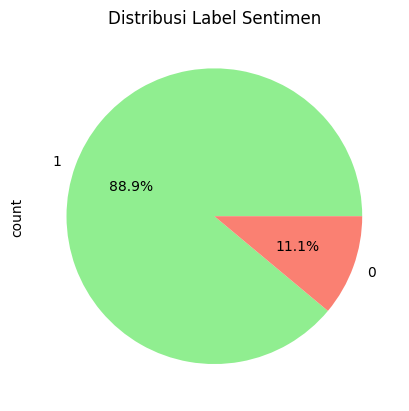

In [45]:
df['label'].value_counts().plot(
    kind='pie',
    labels=['1', '0'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'salmon']
)
plt.title('Distribusi Label Sentimen')
plt.show()

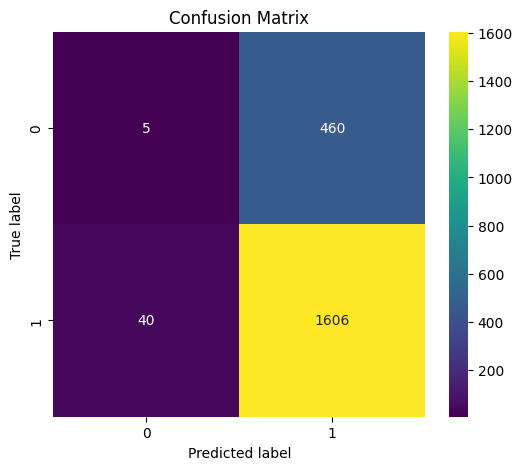

In [46]:
# 1. Prediksi
y_pred = best_model.predict(X_test_tfidf)

# 2. Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
